# **Random Searches based Soft Sensor Code**
**Step 1. Reset all variables and import the required libraries.**

In [1]:
%reset -f
import pandas as pd
from random import random
from random import uniform
from array import array
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from IPython.display import display, Latex, Math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

**Step 2. Mount the Google drive to access the dataset.**

In [2]:
# Importing the df
df = pd.read_csv('./Project_Data_Complete.csv')

Now, the data set has been loaded, let's check:

*   its format.



In [3]:
#Checking the data
df.head(2)

,Pressure,Valve,Flow,Production
0,8.674923,44.113487,1696.772217,4865.154
1,8.712719,43.873474,1713.576782,5322.134


*   summary statistics.

In [4]:
df.describe()

,Pressure,Valve,Flow,Production
count,17407.000000,17407.000000,17407.000000,17407.000000
mean,8.910815,42.396039,1640.325130,4634.789296
std,0.325651,1.804649,139.118306,309.014918
min,7.167935,27.277819,1005.629150,4000.105000
25%,8.700829,41.244404,1565.077697,4421.240500
50%,8.910898,42.212055,1639.051147,4626.579000
75%,9.130732,43.456560,1706.833923,4829.805500
max,11.285064,61.130039,2209.434082,7939.757000




*   its distribution.



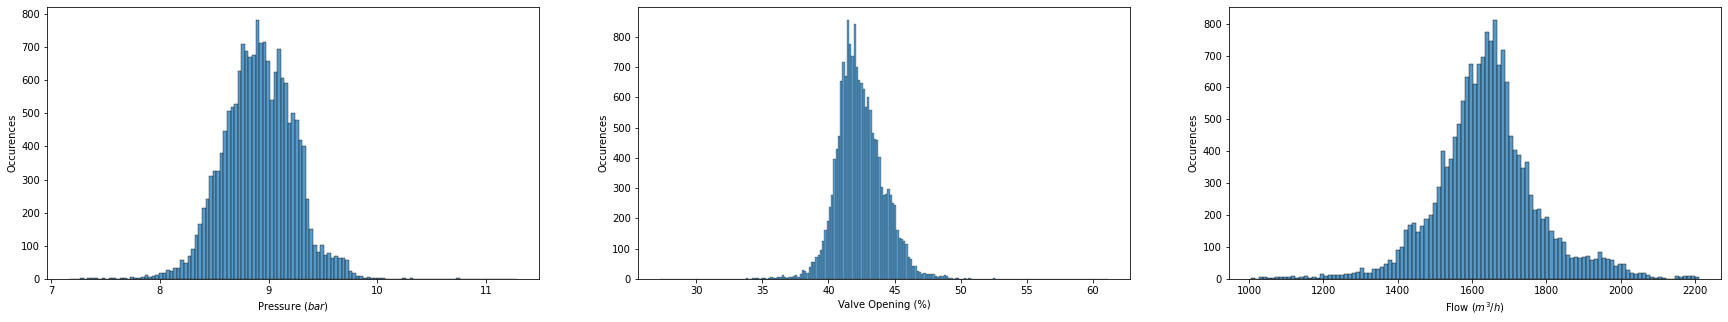

In [5]:
# Set up the plot
#Figure size
plt.figure(figsize=(30,5))
#Position and legends
#for P
ax = plt.subplot(1, 3, 1)
plt.ylabel('Occurences')
plt.xlabel('Pressure ($bar$)')
sns.histplot(df["Pressure"]);
#for V
ax = plt.subplot(1, 3, 2)
plt.ylabel('Occurences')
plt.xlabel('Valve Opening (%)')
sns.histplot(df["Valve"]);
#for Q
ax = plt.subplot(1, 3, 3)
plt.ylabel('Occurences')
plt.xlabel('Flow ($m^3/h$)')
sns.histplot(df["Flow"]);
#Show plots
#plt.tight_layout()
plt.show()



*   its quartiles.



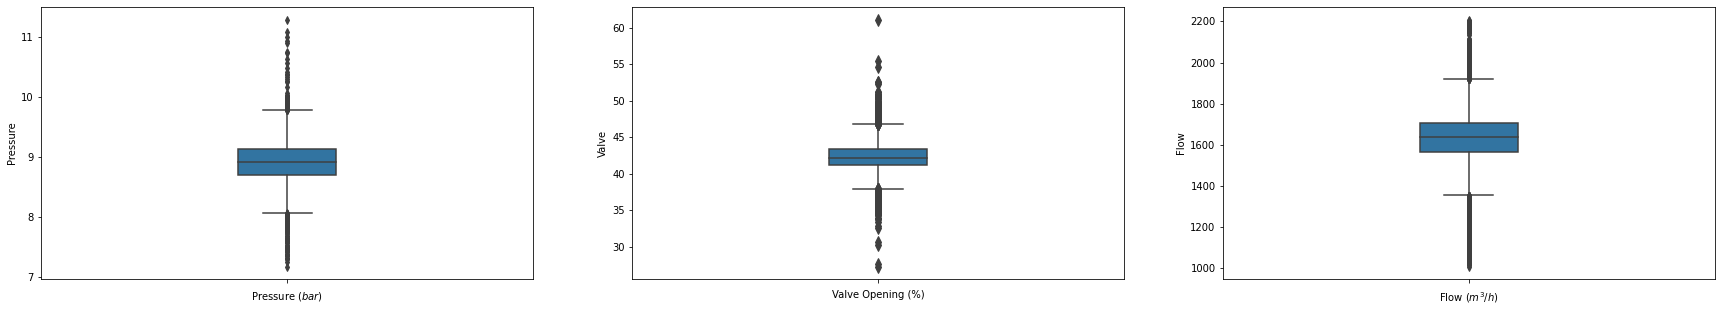

In [6]:
plt.figure(figsize=(30,5))
###############################
ax = plt.subplot(1, 3, 1)
plt.xlabel('Pressure ($bar$)')
sns.boxplot(data = df['Pressure']
            ,y=df["Pressure"]
#            ,orient = "h"
            ,width=0.2);  
###############################
ax = plt.subplot(1, 3, 2)
plt.xlabel('Valve Opening (%)')
sns.boxplot(data = df['Valve']
            ,y=df["Valve"]
#            ,orient = "h"
            ,width=0.2
            ,fliersize=8);  
###############################
ax = plt.subplot(1, 3, 3)
plt.xlabel('Flow ($m^3/h$)')
sns.boxplot(data = df['Flow']
            ,y=df["Flow"]
#            ,orient = "h"
            ,width=0.2);
###############################
plt.show()   

**Step 3. Pre-process the data.**

From the boxplots above, it can be seen many outliers exist. To remove them, the quartiles methods was used and the code is as follows:

In [7]:
#Remove outliers using IQRs
Q1 = df.quantile(q=.25)
Q3 = df.quantile(q=.75)
IQR = df.apply(stats.iqr)
df = df[~((df < (Q1-1.5*IQR)) | (df > (Q3+1.5*IQR))).any(axis=1)]

The result is displayed below.

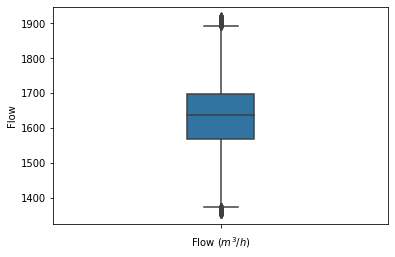

In [8]:
plt.xlabel('Flow ($m^3/h$)')
sns.boxplot(data = df['Flow'],y=df["Flow"],width=0.2);   

Now, we check for **linear** redundancy in the labels with the heat map displayed below.

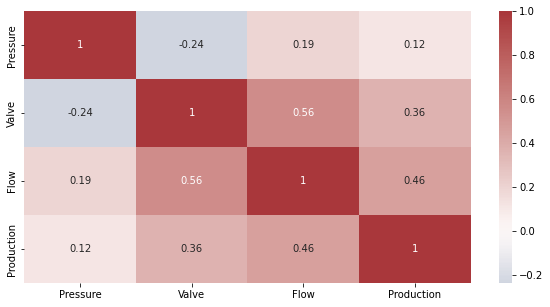

In [9]:
#Check the features corr
plt.figure(figsize=(10,5))
corr = df.corr()
sns.heatmap(corr, annot = True, cmap="vlag", center=0)
#sns.diverging_palette(-1, 1, as_cmap=True)
plt.show()

Since no significant correlation between valve opening and pressure were detected, we assume no linear correlation between them exist. It is worth pointing that the Pearson correlation coefficient only detects linear relationships. Our dataset is probably not linear.


**Step 4. Run the RS algorithm**

Before stating, let's assign the data to our working variables.

In [10]:
#Assign the data
Pl = df.iloc[:,0:1].values.astype(float) #pressure
#print('Pressure at cell 1:',P[0])
Vl = df.iloc[:,1:2].values.astype(float) #valve opening 
#print('Valve opening at cell 1:',V[0])
Ql = df.iloc[:,2:3].values.astype(float) #flow
#print('Flow at cell 1:',Q[0])

In [11]:
#Separate training and test data
tindex = round(0.8*len(Pl))
#Training
P = Pl[0:tindex]
V = Vl[0:tindex]
Q = Ql[0:tindex]

In [12]:
#Test Data
Pt = Pl[tindex:]
Vt = Vl[tindex:]
Qt = Ql[tindex:]

Then, all the functions used in the main code are defined before running the RS search.

In [13]:
###########################################################
#Function 1: Random cv generator, x is the center parameter 
#            and ran defines the % range above and below it.
#            Example: if x = 10 and ran = 1, the output will
#            be anywhere from 0 to 20.
def cv_pred(x,ran):
  #Create an array with random cvs
  cv = [] 
  n = 100
  for i in range(n):
    cv.append(uniform(x-ran*x,x+ran*x)) #range of value
#  for i in range(len(cv)):
#    print(cv[i])
  return cv
###########################################################
#Function 2: SSE Calculator 
def SSE():
  tot_error = []
  for j in range(len(cv)):
    error = []
    Qp = []
    for i in range(len(P)):
    #Calculate the prediction
      Qp.append(V[i]*abs(cv[j])*(P[i]-p_pred)**0.5)
    #print(Qp[i])
    #Calculate the square error
      error.append((Qp[i]-Q[i])**2)
    #print(error[i])
    #Calculate the error sum (SSE)
    tot_error.append(sum(error))
    #print(tot_error[j])
  return tot_error
###########################################################
#Function 3: Non random cv generator. This function simply 
#            assigns values to cv in a ordered fashion.
def cv_line(x,rant):
  #rant = 10 
  #x = 80
  cv_out = []
  range_d = range(-rant,rant)
  for i in range(len(range_d)):
    cv_out.append((1+range_d[i]/100)*x)
  return cv_out
###########################################################
#Function 4: Random cv generator, x is the center parameter 
#            and ran defines the % range above and below it.
#            Example: if x = 10 and ran = 1, the output will
#            be anywhere from 0 to 20.
def cv_ran(x, ran):
   cv_out = []
   range_d = range(-ran,ran)
   for i in range(len(range_d)):
     cv_out[i] = (1+range_d[i]/100)*x
   return cv_out  

Now, all variables are initialized as follows.

In [14]:
#Guess the parameters
#cv_pred = 16.33565
p_pred = 0 #1.8
qt = 0

ran = 1
Qp = []
error = []

cv = cv_pred(50,ran)

#Index = 50

Finally, the $c_v$ random search is done as follows.

In [15]:
#First search looks for the random cv that generates the global SSE minimum
tot_error = SSE()
error_min = min(tot_error)
index = tot_error.index(error_min)
print('Minimum error is: %d, where j is: %d, and cv is: %f' %(error_min,index,cv[index]))
print('Starting search in the neighborhood of %f' %cv[index])
#Now a search around the global minimum is performed.
cv_refined = cv_line(cv[index],100)
cv = cv_refined 
tot_error = SSE()
error_min = min(tot_error)
index = tot_error.index(error_min)
print('Minimum error is: %d, where j is: %d, and cv is: %f' %(error_min,index,cv[index]))

Minimum error is: 182899024, where j is: 80, and cv is: 13.658775
Starting search in the neighborhood of 13.658775
Minimum error is: 82437690, where j is: 95, and cv is: 12.975836


**Step 5. Verify the results.**

Now that the best $c_v$ was found, let's build our prediction using the **test data**.

In [16]:
#Assign the best cv
cv_pred2 = cv[index]
#Build the prediction
Qp = []
for i in range(len(Pt)):
  #Calculate the prediction
  Qp.append(Vt[i]*cv_pred2*(Pt[i]-p_pred)**0.5)

And plot the results.

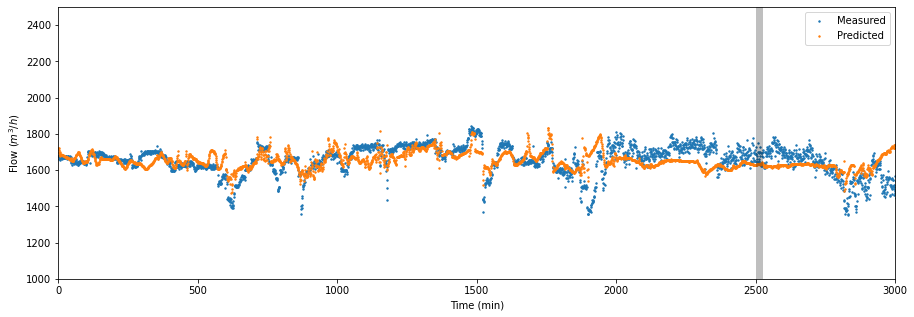

In [27]:
#Before plotting, create a new dimension as time
t = range(len(Pt))
#Plot the results
plt.figure(figsize=(15,5))
plt.xlabel('Time (min)')
plt.ylabel('Flow ($m^3/h$)')
plt.scatter(t,Qt, label = 'Measured', s = 2);
plt.scatter(t,Qp, color = 'tab:orange', label = 'Predicted',s = 2);
plt.xlim([0, 3000])
plt.ylim([1000, 2500])
plt.axvspan(2500, 2525, facecolor='k', alpha=0.25)
plt.legend()
plt.savefig("RS_plot.png", dpi=200)
plt.show()

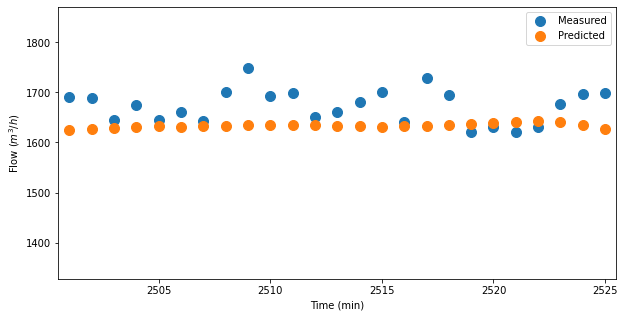

In [26]:
#Before plotting, create a new dimension as time
t = range(len(Pt))
#Plot the results
plt.figure(figsize=(10,5))
plt.xlabel('Time (min)')
plt.ylabel('Flow ($m^3/h$)')
plt.scatter(t,Qt, label = 'Measured', s = 100);
plt.scatter(t,Qp, color = 'tab:orange', label = 'Predicted', s = 100);
plt.xlim([2500.5, 2525.5])
plt.legend()
plt.savefig("RS_plot_zoom.png", dpi=200)
plt.show()

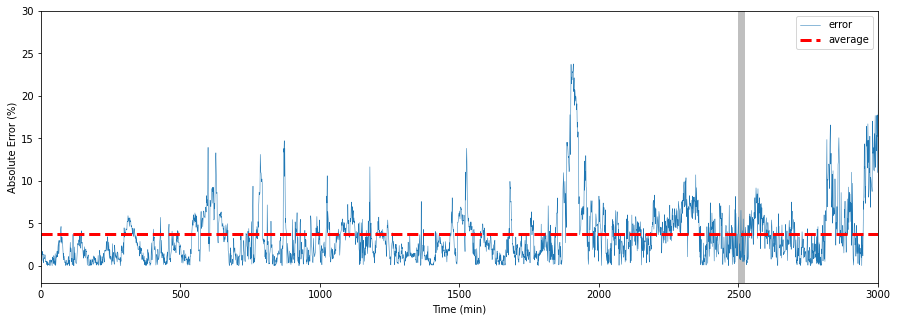

In [25]:
#Before plotting, create a new dimension as time
t = range(len(Qt))

p_error  = abs((Qt-Qp)/Qt)*100
avg_error = np.mean(p_error)
#Plot the results
plt.figure(figsize=(15,5))
plt.xlabel('Time (min)')
plt.ylabel('Absolute Error (%)')
#plt.legend('Experimental')
plt.plot(t, p_error,  label = "error", linewidth = 0.5)
plt.plot([0, 5000], [avg_error, avg_error], "r--", label = "average", linewidth = 3)
plt.xlim([0, 3000])
plt.ylim([-2, 30])
plt.axvspan(2500, 2525, facecolor='k', alpha=0.25)
plt.legend()
plt.savefig("RS_error.png", dpi=200)
plt.show()

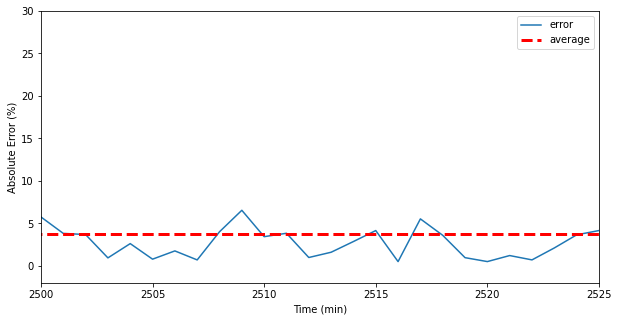

In [24]:
#Before plotting, create a new dimension as time
t = range(len(Qt))

p_error  = abs((Qt-Qp)/Qt)*100
avg_error = np.mean(p_error)
#Plot the results
plt.figure(figsize=(10,5))
plt.xlabel('Time (min)')
plt.ylabel('Absolute Error (%)')
#plt.legend('Experimental')
plt.plot(t, p_error,  label = "error");
plt.plot([0, 5000], [avg_error, avg_error], "r--", label = "average", linewidth = 3)
plt.xlim([2500, 2525])
plt.ylim([-2, 30])
plt.legend()
plt.savefig("RS_error_zoom.png", dpi=200)
plt.show()

Finally, let's evaluate the $R^2$ of the predicted value versus the real value.

In [21]:
#Fit the regression line
reg = LinearRegression()
reg.fit_intercept = False
reg.fit(Qt,Qp)
#Created the trendline
Qreg = reg.predict(Qt)
#Calculate the R2
R2 = r2_score(Qt,Qreg)
print('The calculated R squared is displayed below:')
display(Math(r'R^2 = {}'.format(round(R2,4))))

The calculated R squared is displayed below:


<IPython.core.display.Math object>

And plot the real flow versus the prediction.

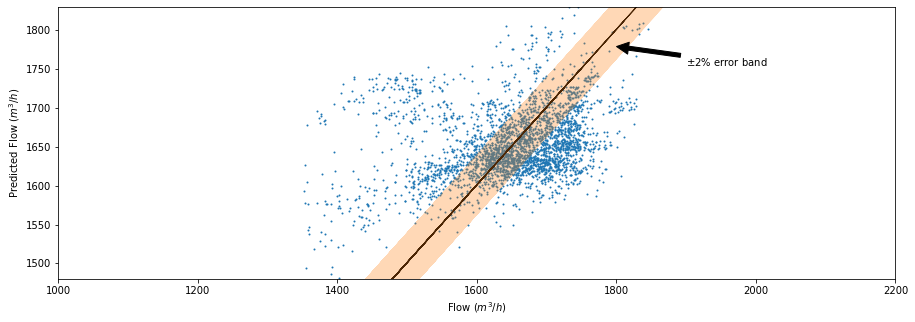

In [23]:
plt.figure(figsize=(15,5))
plt.xlabel('Flow ($m^3/h$)')
plt.ylabel('Predicted Flow ($m^3/h$)')
plt.scatter(Qt,Qp, s = 1)
plt.plot(Qt,Qreg, color = 'k', linewidth = 1)
plt.plot(Qt,Qreg, color = 'tab:orange', alpha = 0.3, linewidth = 40)
plt.xlim([1000, 2200])
plt.ylim([1480, 1830])
plt.annotate('$\pm$2% error band', xy=(1795, 1780),  xycoords='data',
            xytext=(0.75, 0.82), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='top',
            )
plt.savefig("RS_error_bar.png", dpi=200)
plt.show()

Note that as we set the interception to zero, the regression line does not crosses the data at the middle. However, the $R^2$ is very close to one. The explanation is simple, most of the data is correctly predicted but there are still some points that does not obey the flow model. Again, those points are probably the results of process upsets not filtered during the pre-processing of the data.

In [28]:
pwd

'/Users/home/Dropbox/School/PhD/CS791/Project/code'